In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from plotly.offline import init_notebook_mode, plot,iplot

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

init_notebook_mode(connected=True)

datadir = os.path.join('.','data2020', 'players_20.csv')

# Curación

## Curacion de los datos (variables de soporte)

Explicacion de las [features](https://www.fifauteam.com/fifa-20-attributes-guide/)

In [2]:
#######################################################################
cols2keep_obj = list()
cols2keep_num = list()

# Features generales
cols2keep_obj.append('short_name')
cols2keep_obj.append('club')
cols2keep_obj.append('player_positions')
cols2keep_obj.append('preferred_foot')
cols2keep_obj.append('team_position')

cols2keep_num.append('height_cm')
cols2keep_num.append('weight_kg')
cols2keep_num.append('overall')
cols2keep_num.append('work_rate')
cols2keep_num.append('shooting')
cols2keep_num.append('passing')
cols2keep_num.append('dribbling')
cols2keep_num.append('defending')
cols2keep_num.append('physic')

# Features relativas a un arquero
cols2keep_num.append('goalkeeping_diving')
cols2keep_num.append('goalkeeping_handling')
cols2keep_num.append('goalkeeping_kicking')
cols2keep_num.append('goalkeeping_reflexes')
cols2keep_num.append('goalkeeping_positioning')

# Features relativas a la capacidad de ataque
cols2keep_num.append('attacking_crossing')
cols2keep_num.append('attacking_finishing')
cols2keep_num.append('attacking_heading_accuracy')
cols2keep_num.append('attacking_short_passing')
cols2keep_num.append('attacking_volleys')

# Features relativas a las habilidades
cols2keep_num.append('skill_moves')
cols2keep_num.append('skill_dribbling')
cols2keep_num.append('skill_curve')
cols2keep_num.append('skill_fk_accuracy')
cols2keep_num.append('skill_long_passing')
cols2keep_num.append('skill_ball_control')

# Features relativas a la movilidad
cols2keep_num.append('movement_acceleration')
cols2keep_num.append('movement_sprint_speed')
cols2keep_num.append('movement_agility')
cols2keep_num.append('movement_reactions')
cols2keep_num.append('movement_balance')

# Features relativas a la potencia
cols2keep_num.append('power_shot_power')
cols2keep_num.append('power_jumping')
cols2keep_num.append('power_stamina')
cols2keep_num.append('power_strength')
cols2keep_num.append('power_long_shots')

# Features relativas a las soft skills
cols2keep_num.append('mentality_aggression')
cols2keep_num.append('mentality_interceptions')
cols2keep_num.append('mentality_positioning')
cols2keep_num.append('mentality_vision')
cols2keep_num.append('mentality_penalties')
cols2keep_num.append('mentality_composure')

# Features relativas a la defensa
cols2keep_num.append('defending_marking')
cols2keep_num.append('defending_standing_tackle')
cols2keep_num.append('defending_sliding_tackle')

#######################################################################
# Columnas con campos en NaN
cols2fix = list()
cols2fix.append('shooting')
cols2fix.append('passing')
cols2fix.append('dribbling')
cols2fix.append('defending')
cols2fix.append('physic')

# Regla de transformacion de work_rate
regla = dict()
regla['High/High'] = 4
regla['High/Medium'] = 3
regla['High/Low'] = 2
regla['Medium/High'] = 1 
regla['Medium/Medium'] = 0
regla['Medium/Low'] = -1
regla['Low/High'] = -2
regla['Low/Medium'] = -3
regla['Low/Low'] = -4

## Curación de los datos (ejecución)

In [3]:
#1. Cargamos el conjunto de datos fifa 2020
dfn = pd.read_csv(datadir)

#2. Tomamos la metadata que nos interesa `cols2keep_obj` 
dfo = dfn[cols2keep_obj]

#3. Tomamos solo las columnas que nos interesan `cols2keep_num`
dfn = dfn[cols2keep_num]

#4. Se completan con cero las entradas de las columnas `cols2fix` para remover los NaN
dfn[cols2fix] = dfn[cols2fix].fillna(0)

#5. Se completan con "Undef" las entradas de la columna `team_position` para remover los NaN
dfn['work_rate'] = dfn.work_rate.apply(lambda x: regla[x])

#6. S convierte `work_rate` a categorica numérica en el rango [-4, 4]
dfo['team_position'] = dfo.team_position.fillna('Undef')

display(dfo.info())
display('####################')
display(dfn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   short_name        18278 non-null  object
 1   club              18278 non-null  object
 2   player_positions  18278 non-null  object
 3   preferred_foot    18278 non-null  object
 4   team_position     18278 non-null  object
dtypes: object(5)
memory usage: 714.1+ KB


None

'####################'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   height_cm                   18278 non-null  int64  
 1   weight_kg                   18278 non-null  int64  
 2   overall                     18278 non-null  int64  
 3   work_rate                   18278 non-null  int64  
 4   shooting                    18278 non-null  float64
 5   passing                     18278 non-null  float64
 6   dribbling                   18278 non-null  float64
 7   defending                   18278 non-null  float64
 8   physic                      18278 non-null  float64
 9   goalkeeping_diving          18278 non-null  int64  
 10  goalkeeping_handling        18278 non-null  int64  
 11  goalkeeping_kicking         18278 non-null  int64  
 12  goalkeeping_reflexes        18278 non-null  int64  
 13  goalkeeping_positioning     182

None

In [4]:
dfo = dfo[dfn.overall>70]
dfn = dfn[dfn.overall>70]
display(dfo.shape, dfn.shape)

(4756, 5)

(4756, 44)

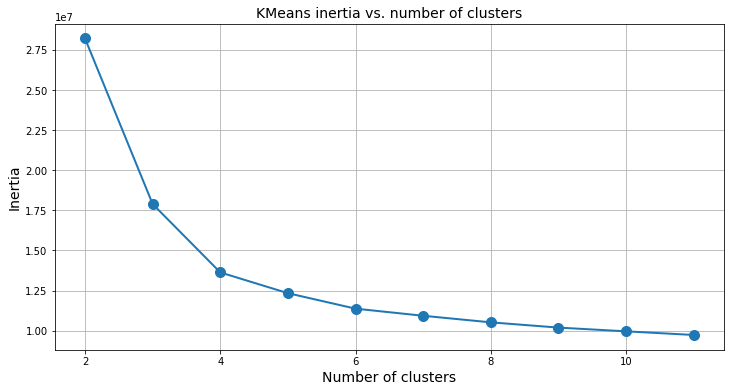

In [5]:
N = 10
inertias = [KMeans(n_clusters=i+2).fit(dfn).inertia_ for i in range(10)]

plt.figure(figsize=(12,6))
plt.plot(np.arange(2, N+2), inertias, '-o', markersize=10,linewidth=2)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("KMeans inertia vs. number of clusters", fontsize=14)
plt.grid(True)

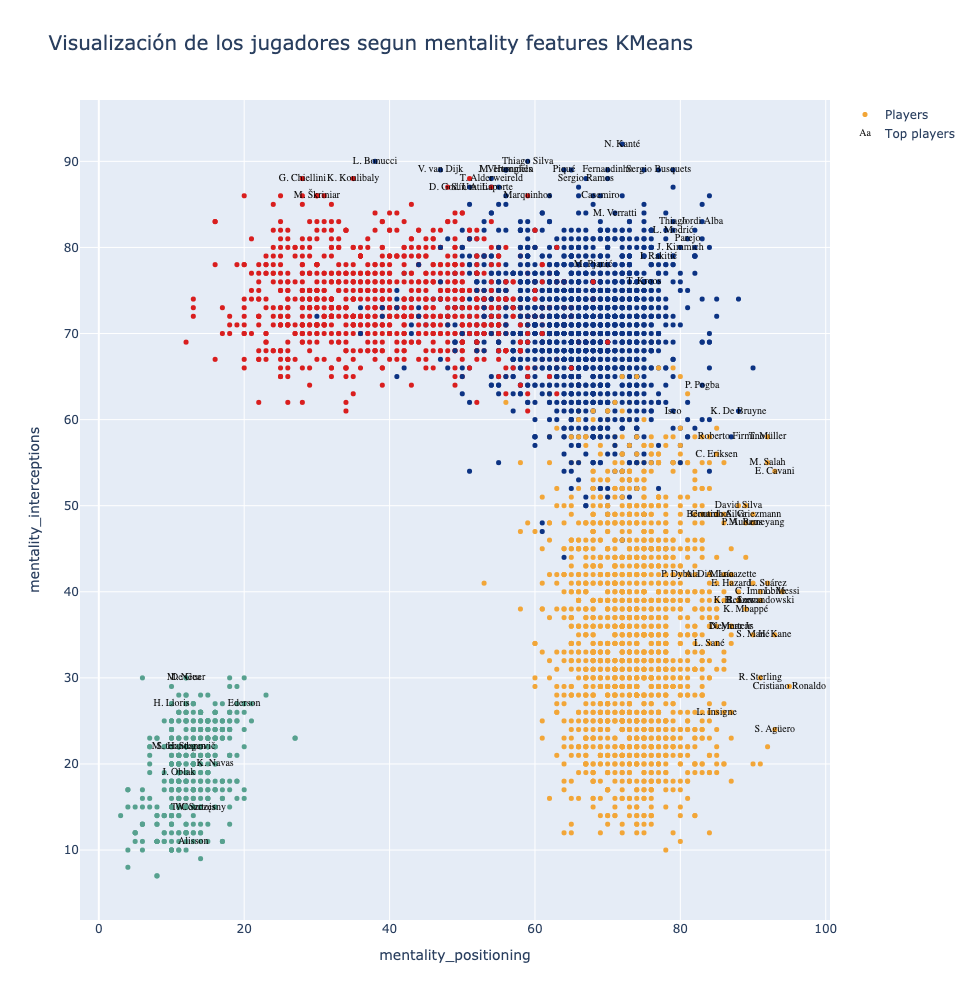

In [6]:
n_clusters = 4

km = KMeans(n_clusters=n_clusters)
km.fit(dfn)

clusters = km.labels_
skill_1 = 'mentality_positioning'
skill_2 = 'mentality_interceptions'
bool_crack = dfn.overall>85

graf1 = go.Scatter(x=dfn[skill_1], 
                   y=dfn[skill_2],
                   name='Players',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   mode='markers',
                   marker=dict(size=5,
                   color = clusters.astype(np.float),
                   colorscale='Portland',
                   showscale=False))

crack =go.Scatter(x=dfn.loc[bool_crack,skill_1], 
                  y=dfn.loc[bool_crack,skill_2],
                  name='Top players',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de los jugadores segun mentality features KMeans", 
                   titlefont=dict(size=20),
                   xaxis=dict(title=skill_1),
                   yaxis=dict(title=skill_2),
                   autosize=False,
                   width=1000,
                   height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

'Ancho de banda estimado: 94'

'Numero estimado de clusters para Mean Shift : 2'

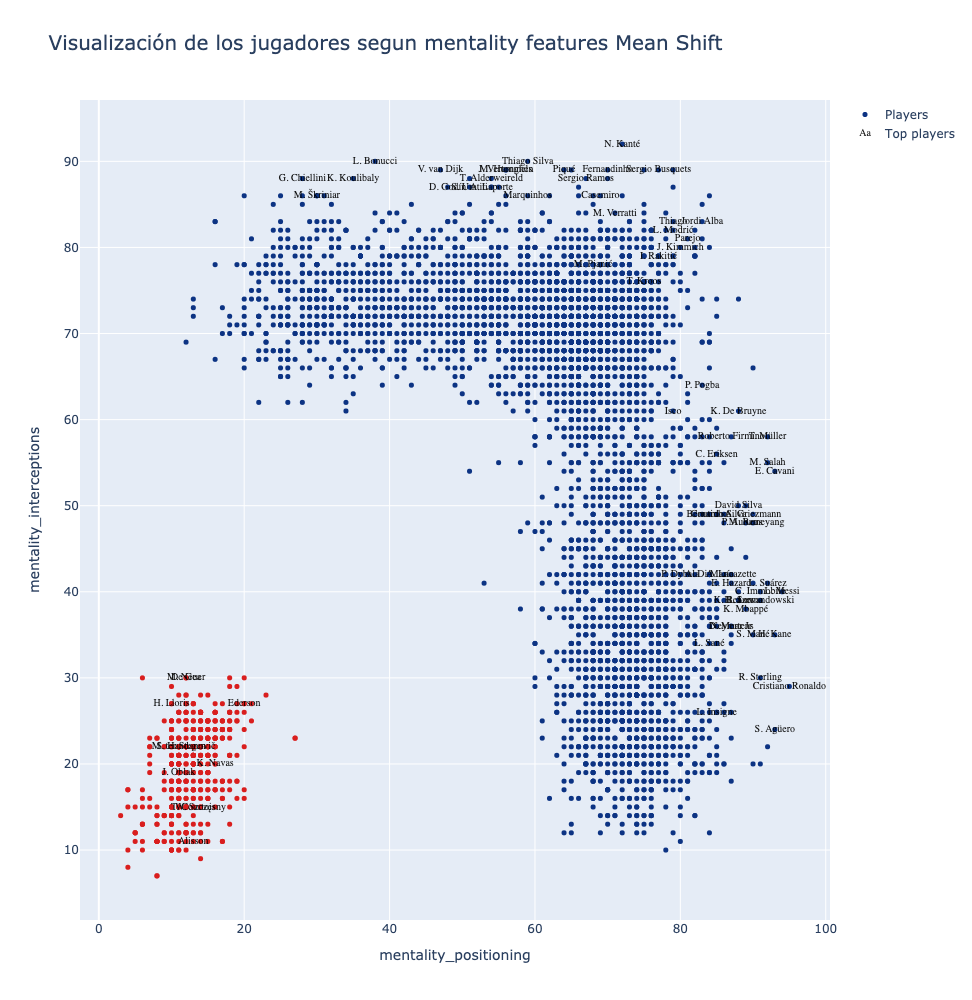

In [7]:
bw = estimate_bandwidth(dfn, quantile=0.2)#, n_samples=1000)

display(f"Ancho de banda estimado: {int(bw)}")

ms = MeanShift(bandwidth=int(bw), n_jobs=2)#, bin_seeding=True)
ms.fit(dfn)

skill_1 = 'mentality_positioning'
skill_2 = 'mentality_interceptions'
clusters = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(clusters))
bool_crack = dfn.overall>85

display(f"Numero estimado de clusters para Mean Shift : {n_clusters}")


graf1 = go.Scatter(x=dfn[skill_1], 
                   y=dfn[skill_2],
                   name='Players',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   mode='markers',
                   marker=dict(size=5,
                   color = clusters.astype(np.float),
                   colorscale='Portland',
                   showscale=False))

crack =go.Scatter(x=dfn.loc[bool_crack,skill_1], 
                  y=dfn.loc[bool_crack,skill_2],
                  name='Top players',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de los jugadores segun mentality features Mean Shift", 
                   titlefont=dict(size=20),
                   xaxis=dict(title=skill_1),
                   yaxis=dict(title=skill_2),
                   autosize=False,
                   width=1000,
                   height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [11]:
dfo[(dfo.team_position=='GK') | (dfo.player_positions=='GK')]

,short_name,club,player_positions,preferred_foot,team_position
3,J. Oblak,Atlético Madrid,GK,Right,GK
6,M. ter Stegen,FC Barcelona,GK,Right,GK
13,Alisson,Liverpool,GK,Right,GK
14,De Gea,Manchester United,GK,Right,GK
25,Ederson,Manchester City,GK,Left,GK
...,...,...,...,...,...
4690,S. Torrico,San Lorenzo de Almagro,GK,Right,SUB
4717,André Milazisco,Atlético Paranaense,GK,Left,SUB
4718,Wiliam Santinho,Fluminense,GK,Right,SUB
4738,Nathael Silbeira,Cruzeiro,GK,Right,SUB


---------------
# Repetimos pero sin los arqueros

In [12]:
dfn = dfn[(dfo.team_position!='GK') & (dfo.player_positions!='GK')]
dfo = dfo[(dfo.team_position!='GK') & (dfo.player_positions!='GK')]
display(dfn.shape, dfo.shape)

(4316, 44)

(4316, 5)

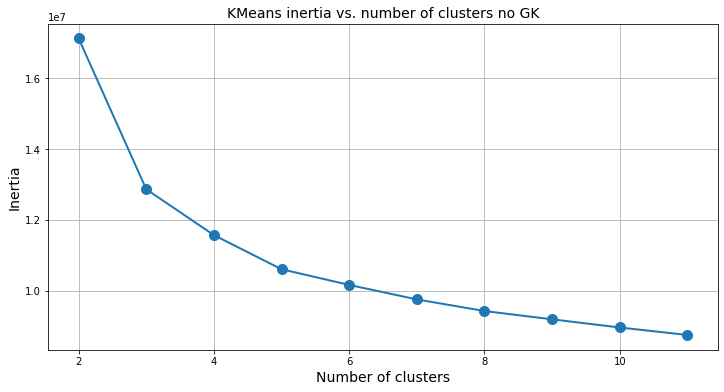

In [13]:
N = 10
inertias = [KMeans(n_clusters=i+2).fit(dfn).inertia_ for i in range(10)]

plt.figure(figsize=(12,6))
plt.plot(np.arange(2, N+2), inertias, '-o', markersize=10,linewidth=2)
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("KMeans inertia vs. number of clusters no GK", fontsize=14)
plt.grid(True)

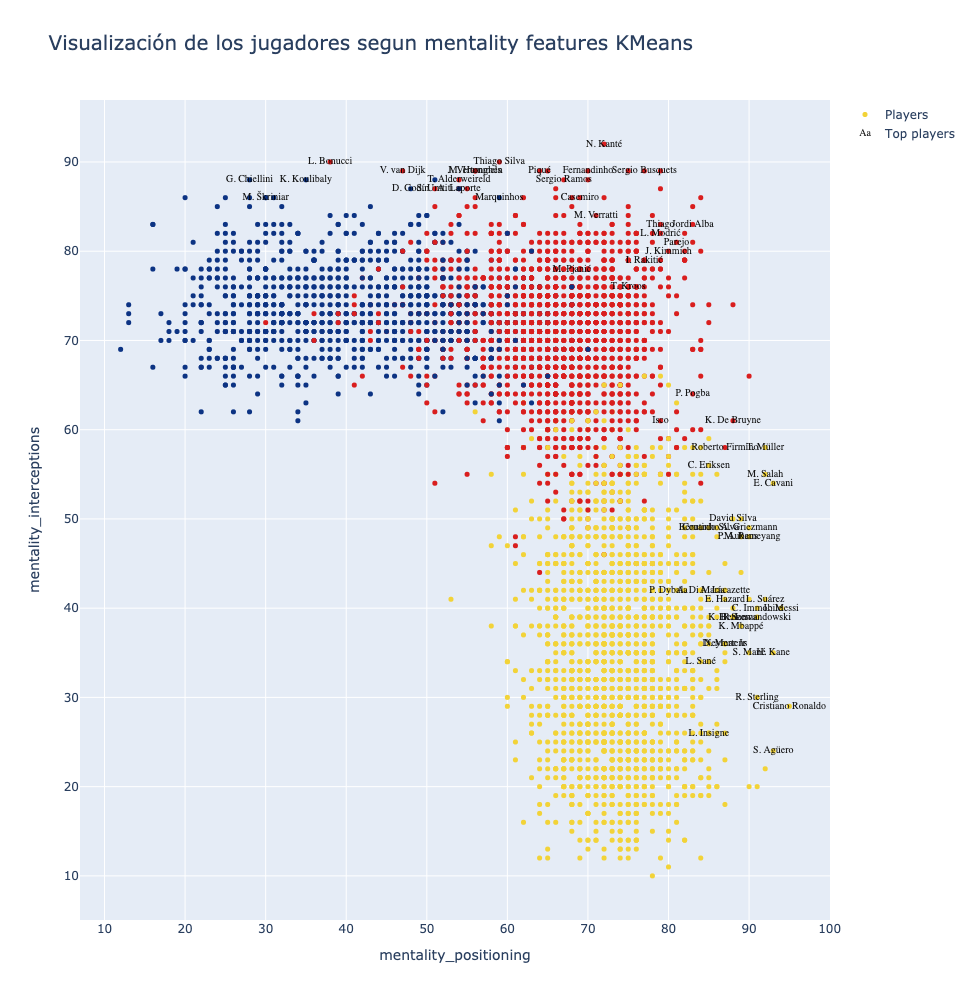

In [14]:
n_clusters = 3

km = KMeans(n_clusters=n_clusters)
km.fit(dfn)

clusters = km.labels_
skill_1 = 'mentality_positioning'
skill_2 = 'mentality_interceptions'
bool_crack = dfn.overall>85

graf1 = go.Scatter(x=dfn[skill_1], 
                   y=dfn[skill_2],
                   name='Players',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   mode='markers',
                   marker=dict(size=5,
                   color = clusters.astype(np.float),
                   colorscale='Portland',
                   showscale=False))

crack =go.Scatter(x=dfn.loc[bool_crack,skill_1], 
                  y=dfn.loc[bool_crack,skill_2],
                  name='Top players',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de los jugadores segun mentality features KMeans", 
                   titlefont=dict(size=20),
                   xaxis=dict(title=skill_1),
                   yaxis=dict(title=skill_2),
                   autosize=False,
                   width=1000,
                   height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

'Ancho de banda estimado: 74'

'Numero estimado de clusters para Mean Shift : 1'

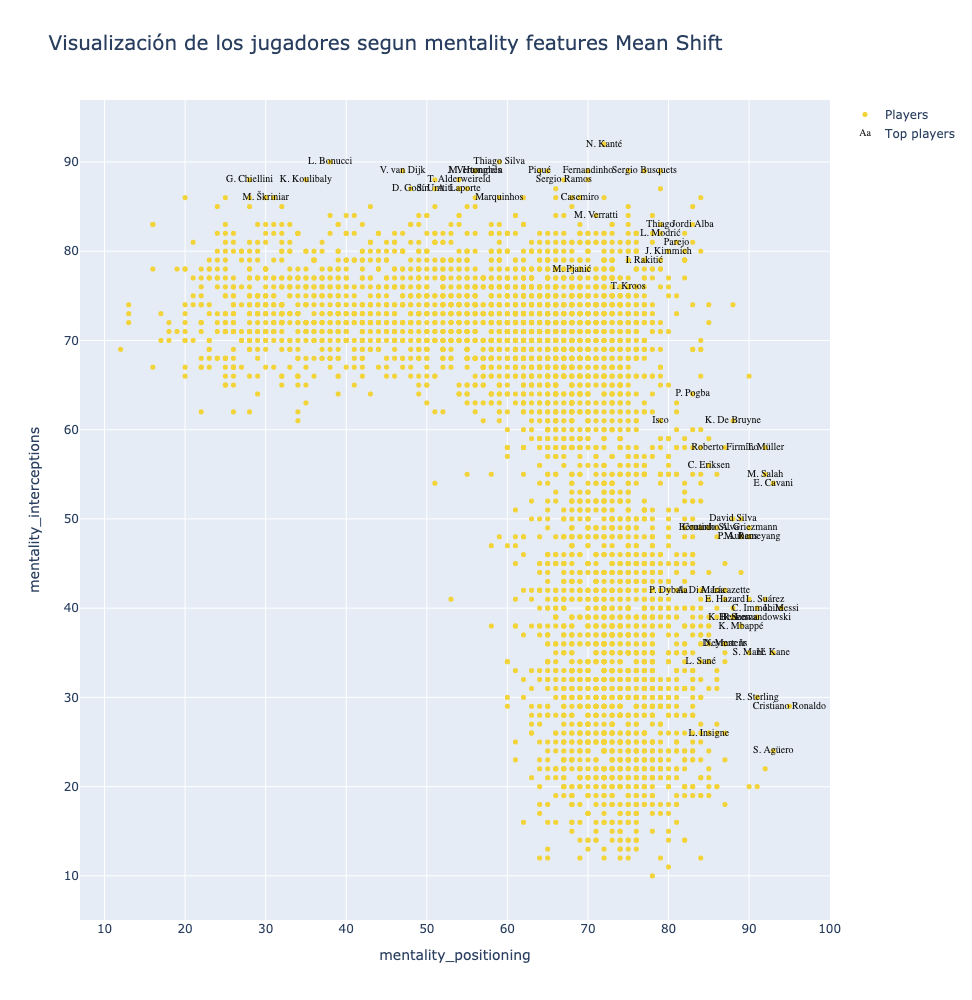

In [22]:
bw = estimate_bandwidth(dfn, quantile=0.2, n_jobs=2)#, n_samples=1000)

display(f"Ancho de banda estimado: {int(bw)}")

ms = MeanShift(bandwidth=int(bw), n_jobs=2, bin_seeding=True)
ms.fit(dfn)

skill_1 = 'mentality_positioning'
skill_2 = 'mentality_interceptions'
clusters = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(clusters))
bool_crack = dfn.overall>85

display(f"Numero estimado de clusters para Mean Shift : {n_clusters}")


graf1 = go.Scatter(x=dfn[skill_1], 
                   y=dfn[skill_2],
                   name='Players',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   mode='markers',
                   marker=dict(size=5,
                   color = clusters.astype(np.float),
                   colorscale='Portland',
                   showscale=False))

crack =go.Scatter(x=dfn.loc[bool_crack,skill_1], 
                  y=dfn.loc[bool_crack,skill_2],
                  name='Top players',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de los jugadores segun mentality features Mean Shift", 
                   titlefont=dict(size=20),
                   xaxis=dict(title=skill_1),
                   yaxis=dict(title=skill_2),
                   autosize=False,
                   width=1000,
                   height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [13]:
MachineGunDict=dict()
for col in cols2keep:
    MachineGunDict[col]=99
MachineGunDict['short_name'] = 'Machine Gun'
df=df.append(MachineGunDict,ignore_index=True)
df.tail()

NameError: name 'cols2keep' is not defined